# APERO Demos

The aim of these demos is to walk you through some of the key steps in the
data reduction using APERO.

## Prerequisites for exercises

- Python 3.9  (e.g. via [conda](https://docs.conda.io/en/latest/miniconda.html))
    ```
    conda create --name=apero-demo python=3.9
    conda activate apero-demo
    pip install -r requirements.txt
    ```


- DS9 ([download](https://sites.google.com/cfa.harvard.edu/saoimageds9))


- dfits and fitsort
  - python implementation: [download](https://astrom-tom.github.io/dfitspy/build/html/installation.html)
  - C implmentation: [download](https://github.com/granttremblay/eso_fits_tools)


- Download the file bundle: [download](https://www.astro.umontreal.ca/~artigau/apero_demo/apero_nirps_demo.tar)


## Exercise 6: Radial velocities using the line-by-line approach

- Step 1: Get the tcorr LBL file for Proxima
- Step 2: Get the associated recon file for the tcorr Proxima file.
- Step 3: Plot a histogram of the sigma away from the mean velocity
- Step 4: Plot the “trumpet plot” with the 3.5 sigma outliers and see if they match absorption features.

In [32]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from scipy.optimize import curve_fit

In [33]:
# notebook only
%matplotlib inline

In [34]:
def gaussian(xvector, ew, amp):
    """
    Gaussian model
    :param xvector: x pixel positions
    :param ew: equivlent width (FWHM)
    :param amp: the amplitude of the gaussian

    :return: np.array, same size as xpix
    """
    # gaussian fit centered at zero
    yvector = np.exp(-0.5 * (xvector / ew) ** 2) * amp
    return yvector

In [35]:
def odd_ratio_mean(value, error, odd_ratio=1e-4, nmax=10,
                   conv_cut=1e-2):
    """
    Provide values and corresponding errors and compute a weighted mean
    advanced way to do the weighted mean and error on the weighted mean

    :param value: np.array (1D), value array
    :param error: np.array (1D), uncertainties for value array
    :param odd_ratio: float, the probability that the point is bad
                    Recommended value in Artigau et al. 2021 : f0 = 0.002
    :param nmax: int, maximum number of iterations to pass through
    :param conv_cut: float, the convergence cut criteria - how precise we have
                     to get

    :return: tuple, 1. the weighted mean, 2. the error on weighted mean
    """
    # deal with NaNs in value or error
    keep = np.isfinite(value) & np.isfinite(error)
    # deal with no finite values
    if np.sum(keep) == 0:
        return np.nan, np.nan
    # remove NaNs from arrays
    value, error = value[keep], error[keep]
    # work out some values to speed up loop
    error2 = error ** 2
    # placeholders for the "while" below
    guess_prev = np.inf
    # the 'guess' must be started as close as we possibly can to the actual
    # value. Starting beyond ~3 sigma (or whatever the odd_ratio implies)
    # would lead to the rejection of pretty much all points and would
    # completely mess the convergence of the loop
    guess = np.nanmedian(value)
    bulk_error = 1.0
    ite = 0
    # loop around until we do all required iterations
    while (np.abs(guess - guess_prev) / bulk_error > conv_cut) and (ite < nmax):
        # store the previous guess
        guess_prev = float(guess)
        # model points as gaussian weighted by likelihood of being a valid point
        # nearly but not exactly one for low-sigma values
        gfit = (1 - odd_ratio) * np.exp(-0.5 * ((value - guess) ** 2 / error2))
        # find the probability that a point is bad
        odd_bad = odd_ratio / (gfit + odd_ratio)
        # find the probability that a point is good
        odd_good = 1 - odd_bad
        # calculate the weights based on the probability of being good
        weights = odd_good / error2
        # update the guess based on the weights
        if np.sum(np.isfinite(weights)) == 0:
            guess = np.nan
        else:
            guess = np.nansum(value * weights) / np.nansum(weights)
            # work out the bulk error
            bulk_error = np.sqrt(1.0 / np.nansum(odd_good / error2))
        # keep track of the number of iterations
        ite += 1
    # return the guess and bulk error
    return guess, bulk_error

In [36]:
# relevant files
file_lblrv = 'NIRPS_2023-01-20T08_42_08_941_pp_e2dsff_tcorr_A_PROXIMA_PROXIMA_lbl.fits'
file_recon = 'NIRPS_2023-01-20T08_42_08_941_pp_s1d_v_recon_A.fits'

In [37]:
# reconstructed absorption
recon = Table.read(file_recon, hdu=1)
# read the LBL file
tbl = Table.read(file_lblrv, hdu=1)
# get vectors as numpy arrays
dv = np.array(tbl['dv'])
sdv = np.array(tbl['sdv'])

In [38]:
# anything with <20 m/s per line is suspect. To be discussed with team
bad = sdv < 20
dv[bad] = np.nan
sdv[bad] = np.nan

# keep only valid entries in the table
tbl = tbl[np.isfinite(dv)]

In [39]:
# get the mean velocity
# the best way is with a weighted mean
mu, sig = odd_ratio_mean(dv, sdv)
# but as a simple example we could just take a median and sig of good lines
good_lines = (sdv) > 20 & (sdv < 200)
mu_alt = np.nanmedian(dv[good_lines])
sig_alt = np.nanstd(dv[good_lines])/np.sqrt(np.sum(good_lines) - 1)

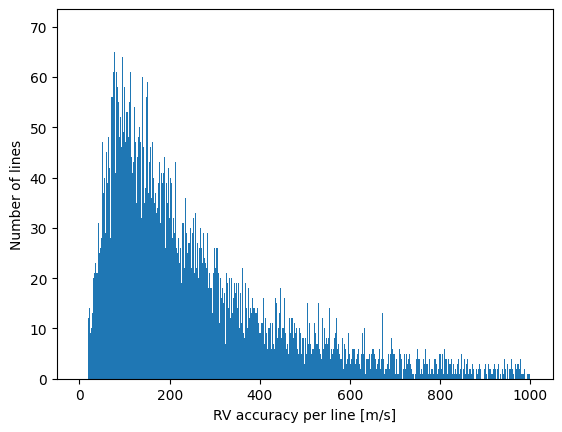

In [40]:

# plot the histogram of RV accuracy per line
v = np.array(sdv)
plt.hist(v[np.isfinite(v)], range=[0, 1000], bins=1000)
plt.xlabel('RV accuracy per line [m/s]')
plt.ylabel('Number of lines')
plt.show()

Dispersion relative to expected : 0.9887


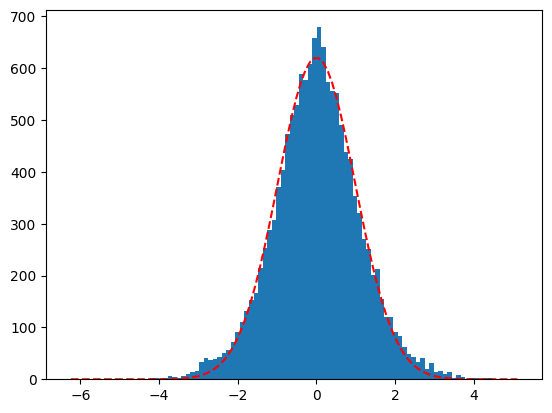

In [41]:
# N sigma of each line relative to the mean velocity
nsig = np.array((tbl['dv'] - mu) / tbl['sdv'])
# distribution of N sigma
xh = plt.hist(nsig[np.isfinite(nsig)], bins=100)
yy = xh[0]
xx = (xh[1][:-1] + xh[1][1:]) / 2.0

# starting point for the curve fit
guess = [1.0, np.max(yy)]
# gaussian curve fit to the distribution
fit, _ = curve_fit(gaussian, xx, yy, p0=guess)
print('Dispersion relative to expected : {:.4f}'.format(fit[0]))

# plot this dispersion
plt.plot(xx, gaussian(xx, *fit), 'r--')


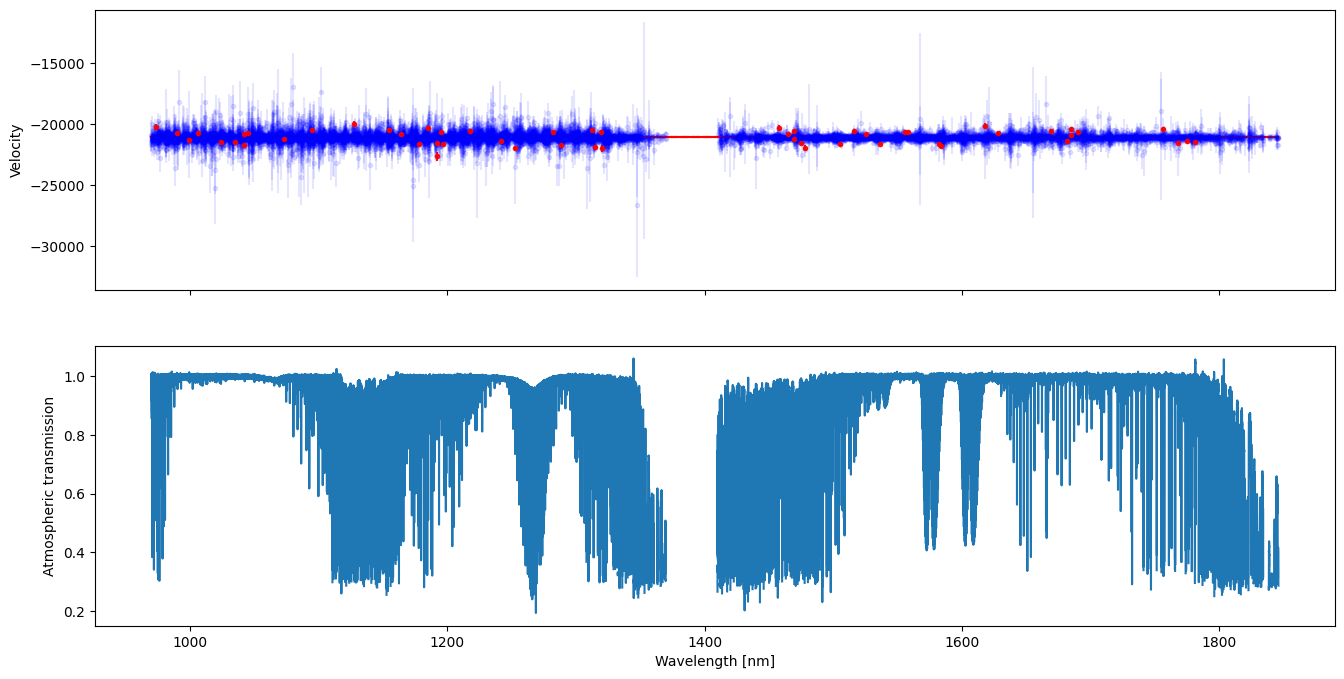

In [42]:
# plot  the position of spurious points compared to telluric absorption
spurious = np.abs(nsig) > 3.5
fig, ax = plt.subplots(nrows=2, ncols=1, sharex='all', figsize=(16, 8))
# for each line, get the central position
ww = (tbl['WAVE_START'] + tbl['WAVE_END']) / 2.0
# get the width of each line
err_wave = (tbl['WAVE_END'] - tbl['WAVE_START']) / 2.0
ax[0].errorbar(ww, tbl['dv'], yerr=tbl['sdv'], xerr=err_wave, fmt='b.',
               alpha=0.1)
ax[0].errorbar(ww[spurious], tbl['dv'][spurious], yerr=tbl['sdv'][spurious],
               xerr=err_wave[spurious], fmt='r.', alpha=0.9)
# overplot the 1-sigma velocity error
ax[0].plot([np.min(tbl['WAVE_START']), np.max(tbl['WAVE_START'])],
           [mu, mu], 'r-')
ax[0].plot([np.min(tbl['WAVE_START']), np.max(tbl['WAVE_START'])],
           [mu - sig, mu - sig], 'r--')
ax[0].plot([np.min(tbl['WAVE_START']), np.max(tbl['WAVE_START'])],
           [mu + sig, mu + sig], 'r--')
ax[0].set(ylabel='Velocity')
# plot telluric absorption
ax[1].plot(recon['wavelength'], recon['flux'])
ax[1].set(xlabel='Wavelength [nm]', ylabel='Atmospheric transmission')
plt.show()
